In [6]:
import numpy as np
from scipy.interpolate import interp1d
import qnm_filter
import sys
import qnm
import random
import argparse
from scipy.special import logsumexp
from pathlib import Path
import matplotlib.pyplot as pl
import glob
from gwpy.timeseries import TimeSeries

In [2]:
def noise_generator():
    global noise
    fsamp = 1*4096
    delta_t = 1/fsamp
    t0 = 0
    duration = 4
    time = np.arange(duration*fsamp)*delta_t + t0
    
    data_psd = TimeSeries.read('H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5', format='hdf5.gwosc').psd()

    qnm_noise = qnm_filter.Noise(freq=data_psd.frequencies, psd=data_psd.value)
    ifo = qnm_filter.set_bilby_ifo(qnm_noise, sampling_frequency=fsamp, duration=duration, start_time=t0,
    				    minimum_frequency=10, maximum_frequency=2000)
    noise = ifo.strain_data.time_domain_strain

In [23]:
def signal_creator(noise_scale):
    global signal, signal220, t_range, mass
    mass_in_solar = random.uniform(50, 120)
    chi_inject = random.uniform(0.0, 0.95)
    injected = (mass_in_solar, chi_inject)
    mass = qnm_filter.Filter.mass_unit(injected[0])
    omega220 = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]

    mmax = 8.4 * 1e-21 * noise_scale
    phase1 = random.uniform(0, 2*np.pi)
    A220x = mmax*np.cos(phase1)
    A220y = mmax*np.sin(phase1)

    sampling_frequency = 4096 * 1  # in Hz
    duration = 4  # in second
    t_range = np.arange(-duration / 2, duration / 2, 1 / sampling_frequency)
    signal220 = np.real((A220x + 1j * A220y) * np.exp(-1j * omega220 * np.abs(t_range / mass)))
    
    signal = signal220+noise

def injection_evidence():
    fit = qnm_filter.Network(segment_length=0.2, srate=4096 * 1, t_init=3.0*mass)
    fit.original_data['H1'] = qnm_filter.RealData(signal, index=t_range)
    fit.detector_alignment()
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.RealData(noise, index=t_range)
    fit.condition_data('original_data')
    fit.condition_data('pure_noise')
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()
    
    fit.pure_nr = {}
    fit.pure_nr["H1"] = qnm_filter.RealData(signal220, index=t_range, ifo="H1")
    fit.condition_data('pure_nr')
    SNRtot_MF = fit.compute_SNR(
        fit.truncate_data(fit.original_data)["H1"],
        fit.truncate_data(fit.pure_nr)["H1"],
        "H1",
        False,
    )
    
    SNRtot_opt = fit.compute_SNR(
        None,
        fit.truncate_data(fit.pure_nr)["H1"],
        "H1",
        True,
    )
    
    return np.array([SNRtot_opt])

In [24]:
result = []
noise_generator()

noise_space = np.linspace(0.1,2,20)
for i in noise_space:
    signal_creator(i)
    result.append(injection_evidence())

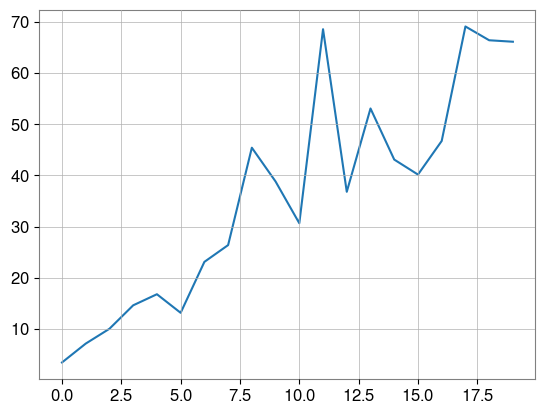

In [25]:
pl.plot(result)